# Analyze SARS-CoV-2 Strain B.1.1.7
[Work in progress]

This notebook queries the Knowledge Graph for Strains with the B.1.1.7 lineage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator, WeekdayLocator
#import seaborn as sns
from py2neo import Graph

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

##### Connect to COVID-19-Community Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

In [4]:
lineage = 'B.1.1.7'
taxonomy_id = 'taxonomy:2697049' # SARS-CoV-2

## Get Number of B.1.1.7 Strains

In [5]:
query = """
MATCH (s:Strain)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
RETURN count(s) AS count
"""
strains = graph.run(query, lineage=lineage, taxonomy_id=taxonomy_id).data()

In [6]:
n_strains = strains[0]['count']

In [7]:
print('Number of B.1.1.7 strains:', n_strains)

Number of B.1.1.7 strains: 3045


## Strain B.1.1.7 Time Series by Country

In [8]:
query = """
MATCH (s:Strain)-[:FOUND_IN*]->(c:Country)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
RETURN DISTINCT(s.collectionDate) AS collectionDate, c.name AS country, count(s) AS count
ORDER BY collectionDate
"""
df_country = graph.run(query, lineage=lineage, taxonomy_id=taxonomy_id).to_data_frame()

In [9]:
# calculate cummulatve sum
df_country['total'] = df_country.groupby(['country'])['count'].cumsum()

In [10]:
# pivot table
df_country = pd.DataFrame(df_country.pivot(index='collectionDate', columns='country', values='total').to_records())
df_country.fillna(method='ffill', inplace=True)

In [11]:
# convert neo4j date to date
df_country['collectionDate'] = df_country['collectionDate'].astype(str)
df_country['collectionDate'] = pd.to_datetime(df_country['collectionDate'], infer_datetime_format=False)
df_country.set_index('collectionDate', inplace=True)

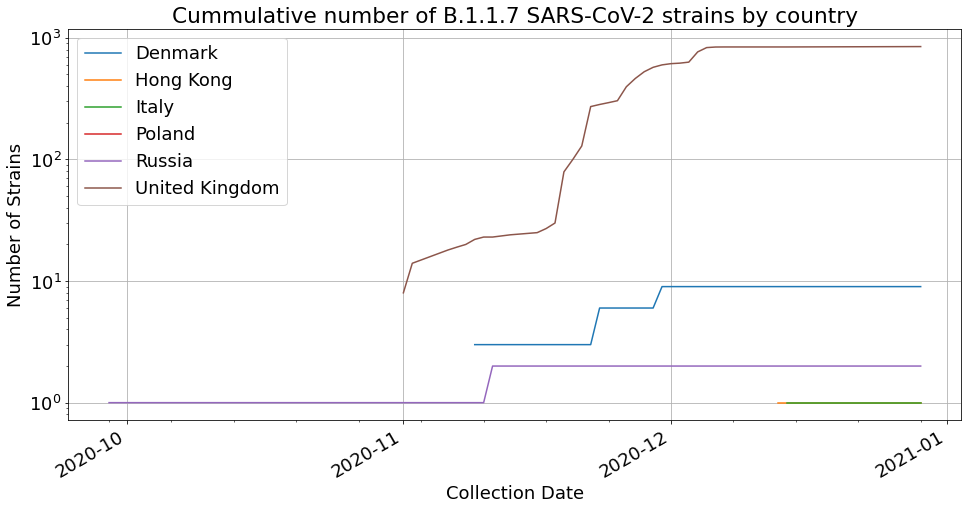

In [12]:
plt.rcParams.update({'font.size': 18})
ax = df_country.plot(figsize=(16, 8), title=f'Cummulative number of {lineage} SARS-CoV-2 strains by country', logy=True);
ax.set_xlabel('Collection Date')
ax.set_ylabel('Number of Strains');
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_minor_locator(WeekdayLocator())
ax.grid(True)

### Strain B.1.1.7 Time Series by State

In [13]:
query = """
MATCH (s:Strain)-[:FOUND_IN*]->(a:Admin1)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
RETURN DISTINCT(s.collectionDate) AS collectionDate, a.name AS state, count(s) AS count
ORDER BY collectionDate
"""
df_state = graph.run(query, lineage=lineage, taxonomy_id=taxonomy_id).to_data_frame()

In [14]:
# calculate cummulatve sum
df_state['total'] = df_state.groupby(['state'])['count'].cumsum()

In [15]:
# pivot table
df_state = pd.DataFrame(df_state.pivot(index='collectionDate', columns='state', values='total').to_records())
df_state.fillna(method='ffill', inplace=True)

In [16]:
# convert neo4j date to date
df_state['collectionDate'] = df_state['collectionDate'].astype(str)
df_state['collectionDate'] = pd.to_datetime(df_state['collectionDate'], infer_datetime_format=False)
df_state.set_index('collectionDate', inplace=True)

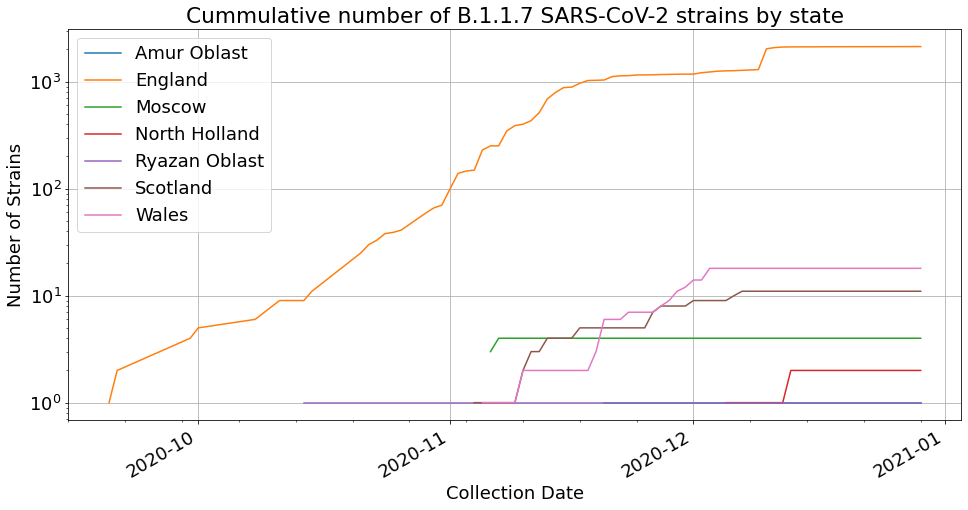

In [17]:
plt.rcParams.update({'font.size': 18})
ax = df_state.plot(figsize=(16, 8), title=f'Cummulative number of {lineage} SARS-CoV-2 strains by state', logy=True)
ax.set_xlabel('Collection Date')
ax.set_ylabel('Number of Strains');
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_minor_locator(WeekdayLocator())
ax.grid(True)

## Strain B.1.1.7 Variant Frequencies

In [18]:
query = """
MATCH (s:Strain)-[:HAS_VARIANT]->(v:Variant)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
RETURN DISTINCT(v.geneVariant) AS geneVariant, split(v.geneVariant, ':')[0] AS gene,
       v.proteinVariant AS proteinVariant, toString(v.proteinPosition) as proteinPosition, 
       v.variantConsequence AS variantConsequense, v.variantType AS variantType, 
       v.start AS start, count(s) AS count
ORDER BY count DESC, start ASC
"""
df_var = graph.run(query, lineage=lineage, taxonomy_id=taxonomy_id).to_data_frame()

In [19]:
df_var['frequency'] = df_var['count'] / n_strains

In [20]:
# TODO add menu: gene, proteinPosition, variantConsequence, variantType

In [21]:
df_var.head(50)

,geneVariant,gene,proteinVariant,proteinPosition,variantConsequense,variantType,start,count,frequency
0,orf1ab,orf1ab,QHD43415.1,None,upstream_gene_variant,SNP,241,2503,0.822003
1,orf1ab:c.2772ttC>ttT,orf1ab,QHD43415.1:p.924F,924,synonymous_variant,SNP,3037,2503,0.822003
2,orf1ab:c.14144cCt>cTt,orf1ab,QHD43415.1:p.4715P>L,4715,missense_variant,SNP,14408,2503,0.822003
3,S:c.1841gAt>gGt,S,QHD43416.1:p.614D>G,614,missense_variant,SNP,23403,2503,0.822003
4,N:c.608aGg>aAg,N,QHD43423.2:p.203R>K,203,missense_variant,SNP,28881,2501,0.821346
5,N:c.609agG>agA,N,QHD43423.2:p.203R,203,synonymous_variant,SNP,28882,2501,0.821346
6,N:c.610Gga>Cga,N,QHD43423.2:p.204G>R,204,missense_variant,SNP,28883,2501,0.821346
7,S:c.2042cCt>cAt,S,QHD43416.1:p.681P>H,681,missense_variant,SNP,23604,2496,0.819704
8,orf1ab:c.3002aCt>aTt,orf1ab,QHD43415.1:p.1001T>I,1001,missense_variant,SNP,3267,2494,0.819048
9,orf1ab:c.5123gCt>gAt,orf1ab,QHD43415.1:p.1708A>D,1708,missense_variant,SNP,5388,2494,0.819048
